# Parte 2 – Clusterização e Classificação (2,5)

 Implementar em contêiner na plataforma o modelo de Clusterização e Classificação desenvolvido na disciplina de Machine Learning.

 1. Criar Clusters de clientes que pedem empréstimo, de acordo com o visto na disciplina de Machine Learning (0,25)

  dica: não utilize a coluna target no processo

 2. Analisar cada cluster atribuindo a ele uma label de “persona”, de acordo com as características identificadas nos centróides (caso use k-means) ou majoritariamente nos grupos (0,25)

 3. Identificar a propensão à fraude média de cada grupo (0,25)

 4. Criar API que retorne i) o grupo a que o cliente pertence; ii) o label de persona; iii) a propensão à fraude média do grupo (0,75)

 5. Encapsular o modelo em um contêiner (1,00).– O Contêiner deve apenas receber os parâmetros de entrada e retornar a propensão da inadimplência

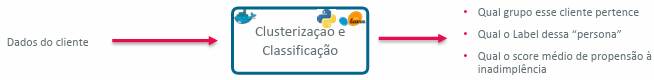

Nota: A API só precisa retornar os dados descritos no requisito 4. A criação de um modelo "fake" que retorna aleatoriamente a saída desejada desabona apenas o 0,75 ponto dos requisitos 1, 2 e 3.

## 1- Criar Clusters de clientes que pedem empréstimo

### Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.colab import auth

import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

### Conexão com o Big Query

In [ ]:
auth.authenticate_user()

In [ ]:
# Aqui devo fazer a conexão em meu próprio projeto (utilizei o rm347975)
project_id = input("Por favor, informe o project_id: ")

Por favor, informe o project_id: rm347975


In [ ]:
clientbq = bigquery.Client(project=project_id)

query_sql = f"""
  SELECT *
  FROM `emf-teacher.trabalho_loans.loan_default`
"""

query_job = clientbq.query(query_sql)  # Make an API request.
loans_data = query_job.to_dataframe()

In [ ]:
loans_data.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.0,148670.0,148670.0,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.0,133572.000000,148670.0,124549.000000
mean,99224.5,2019.0,331117.743997,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,183909.310127,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.0,2019.0,16500.0,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.0,0.967478,0.0,5.000000
25%,62057.25,2019.0,196500.0,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.0,60.474860,0.0,31.000000
50%,99224.5,2019.0,296500.0,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.0,75.135870,0.0,39.000000
75%,136391.75,2019.0,436500.0,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.0,86.184211,0.0,45.000000
max,173559.0,2019.0,3576500.0,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.0,7831.250000,1.0,61.000000


In [ ]:
loans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  Int64  
 1   year                       148670 non-null  Int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  Int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

### Tratativa dos campos

In [ ]:
# Verificar quais colunas possuem valores nulos
print(loans_data.columns[loans_data.isnull().any()])

Index(['loan_limit', 'approv_in_adv', 'loan_purpose', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'property_value', 'income', 'age', 'LTV', 'dtir1'],
      dtype='object')


In [ ]:
# Remover linhas onde as colunas categóricas são nulas
loans_data = loans_data.dropna(subset=['loan_limit'])
loans_data = loans_data.dropna(subset=['approv_in_adv'])
loans_data = loans_data.dropna(subset=['loan_purpose'])
loans_data = loans_data.dropna(subset=['Neg_ammortization'])
loans_data = loans_data.dropna(subset=['age'])

In [ ]:
# Substituir os valores nulos pela mediana
loans_data.loc[:, 'rate_of_interest'] = loans_data['rate_of_interest'].fillna(loans_data['rate_of_interest'].median())
loans_data.loc[:, 'Interest_rate_spread'] = loans_data['Interest_rate_spread'].fillna(loans_data['Interest_rate_spread'].median())
loans_data.loc[:, 'Upfront_charges'] = loans_data['Upfront_charges'].fillna(loans_data['Upfront_charges'].median())
loans_data.loc[:, 'term'] = loans_data['term'].fillna(loans_data['term'].median())
loans_data.loc[:, 'property_value'] = loans_data['property_value'].fillna(loans_data['property_value'].median())
loans_data.loc[:, 'income'] = loans_data['income'].fillna(loans_data['income'].median())
loans_data.loc[:, 'LTV'] = loans_data['LTV'].fillna(loans_data['LTV'].median())
loans_data.loc[:, 'dtir1'] = loans_data['dtir1'].fillna(loans_data['dtir1'].median())

<ipython-input-9-3f16547cb681>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans_data.loc[:, 'rate_of_interest'] = loans_data['rate_of_interest'].fillna(loans_data['rate_of_interest'].median())
<ipython-input-9-3f16547cb681>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans_data.loc[:, 'Interest_rate_spread'] = loans_data['Interest_rate_spread'].fillna(loans_data['Interest_rate_spread'].median())
<ipython-input-9-3f16547cb681>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [ ]:
# Conferindo se sobraram colunas com valores nulos
print(loans_data.columns[loans_data.isnull().any()])

Index([], dtype='object')


In [ ]:
nomes_colunas  =   ["loan_limit",               "approv_in_adv",        "loan_type",
                    "loan_purpose",             "Credit_Worthiness",     "Interest_rate_spread",
                    "Neg_ammortization",        "interest_only",         "lump_sum_payment",
                    "occupancy_type",           "total_units",           "credit_type",
                    "co_applicant_credit_type", "age",                   "submission_of_application",
                    "Region",                   "Status"]
loans_data_classif = loans_data.loc[:, nomes_colunas]

loans_data_classif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143983 entries, 0 to 148669
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 143983 non-null  object 
 1   approv_in_adv              143983 non-null  object 
 2   loan_type                  143983 non-null  object 
 3   loan_purpose               143983 non-null  object 
 4   Credit_Worthiness          143983 non-null  object 
 5   Interest_rate_spread       143983 non-null  float64
 6   Neg_ammortization          143983 non-null  object 
 7   interest_only              143983 non-null  object 
 8   lump_sum_payment           143983 non-null  object 
 9   occupancy_type             143983 non-null  object 
 10  total_units                143983 non-null  object 
 11  credit_type                143983 non-null  object 
 12  co_applicant_credit_type   143983 non-null  object 
 13  age                        14

In [ ]:
# Usando o método one-hot-encode para tratar as variáveis categóricas
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['loan_limit'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['approv_in_adv'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['loan_type'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['loan_purpose'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['Credit_Worthiness'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['Neg_ammortization'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['interest_only'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['lump_sum_payment'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['occupancy_type'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['credit_type'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['total_units'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['co_applicant_credit_type'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['age'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['submission_of_application'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['Region'])

In [ ]:
# Forçando a ordem das colunas definida
ordem_colunas = ['Interest_rate_spread','loan_limit_cf','approv_in_adv_nopre','loan_type_type3','loan_purpose_p4','Credit_Worthiness_l1','Neg_ammortization_not_neg','interest_only_not_int','lump_sum_payment_lpsm','occupancy_type_ir','credit_type_CRIF','total_units_1U','co_applicant_credit_type_EXP','age_25-34','submission_of_application_to_inst','Region_North','loan_limit_ncf','approv_in_adv_pre','loan_type_type1','loan_type_type2','loan_purpose_p1','loan_purpose_p2','loan_purpose_p3','Credit_Worthiness_l2','Neg_ammortization_neg_amm','interest_only_int_only','lump_sum_payment_not_lpsm','occupancy_type_pr','occupancy_type_sr','credit_type_CIB','credit_type_EQUI','credit_type_EXP','total_units_2U','total_units_3U','total_units_4U','co_applicant_credit_type_CIB','age_35-44','age_45-54','age_55-64','age_65-74','age_<25','age_>74','submission_of_application_not_inst','Region_North-East','Region_central','Region_south','Status']
loans_data_classif = loans_data_classif.reindex(columns=ordem_colunas)

In [ ]:
loans_data_classif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143983 entries, 0 to 148669
Data columns (total 47 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Interest_rate_spread                143983 non-null  float64
 1   Status                              143983 non-null  Int64  
 2   loan_limit_cf                       143983 non-null  uint8  
 3   loan_limit_ncf                      143983 non-null  uint8  
 4   approv_in_adv_nopre                 143983 non-null  uint8  
 5   approv_in_adv_pre                   143983 non-null  uint8  
 6   loan_type_type1                     143983 non-null  uint8  
 7   loan_type_type2                     143983 non-null  uint8  
 8   loan_type_type3                     143983 non-null  uint8  
 9   loan_purpose_p1                     143983 non-null  uint8  
 10  loan_purpose_p2                     143983 non-null  uint8  
 11  loan_purpose_p3           

## 2- Analisar cada cluster atribuindo a ele uma label de “persona”, de acordo com as características identificadas nos centróides

### Aplicando K-Means para separar em Clusters

In [ ]:
# Selecionar apenas as colunas que serão usadas para clustering
X = loans_data_classif.drop('Status', axis=1)

In [ ]:
# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Escolher o número de clusters usando o método Elbow
# Aqui usamos um loop para testar diferentes números de clusters e encontrar o melhor
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

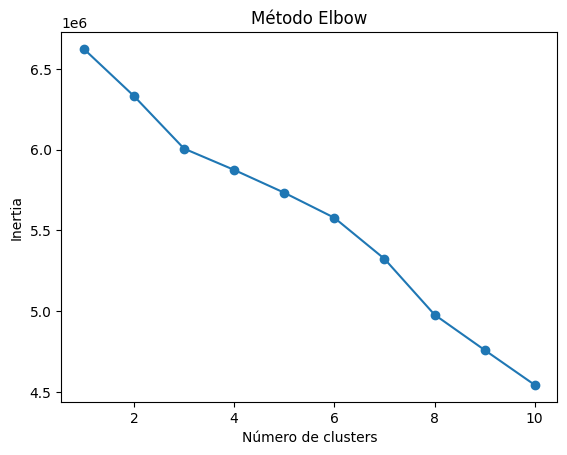

In [ ]:
# Plotar o gráfico do método Elbow
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.title('Método Elbow')
plt.show()

In [ ]:
# Escolher o número de clusters com base no gráfico Elbow
n_clusters = 3  # Pelo que podemos verificar no gráfico, seria 3

In [ ]:
# Treinar o modelo K-means com o número de clusters escolhido acima
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [ ]:
# Adicionar as labels de cluster ao DataFrame original
loans_data_classif['Cluster'] = kmeans.labels_

In [ ]:
# Análise dos clusters e atribuição de personas
cluster_analysis = loans_data_classif.groupby('Cluster').mean(numeric_only=True)

In [ ]:
cluster_analysis

,Interest_rate_spread,loan_limit_cf,approv_in_adv_nopre,loan_type_type3,loan_purpose_p4,Credit_Worthiness_l1,Neg_ammortization_not_neg,interest_only_not_int,lump_sum_payment_lpsm,occupancy_type_ir,...,age_45-54,age_55-64,age_65-74,age_<25,age_>74,submission_of_application_not_inst,Region_North-East,Region_central,Region_south,Status
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.253554,0.927594,0.875831,0.080257,0.488661,1.0,0.923445,0.947017,0.021539,0.067749,...,0.242764,0.157382,0.071613,0.010759,0.020746,0.999024,0.005878,0.059125,0.335977,0.170745
1,0.525739,0.959918,0.949461,0.079689,0.256020,0.0,0.813847,0.903676,0.000792,0.055292,...,0.240494,0.222750,0.143853,0.011882,0.050856,0.305608,0.010456,0.058460,0.418568,0.317966
2,0.514405,0.932817,0.813330,0.112142,0.315296,1.0,0.893259,0.959177,0.026214,0.038111,...,0.228622,0.253164,0.177664,0.007808,0.063794,0.000237,0.009627,0.057986,0.483368,0.280982


### Aplicando PCA para reduzir a dimensionalidade para 2 componentes

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


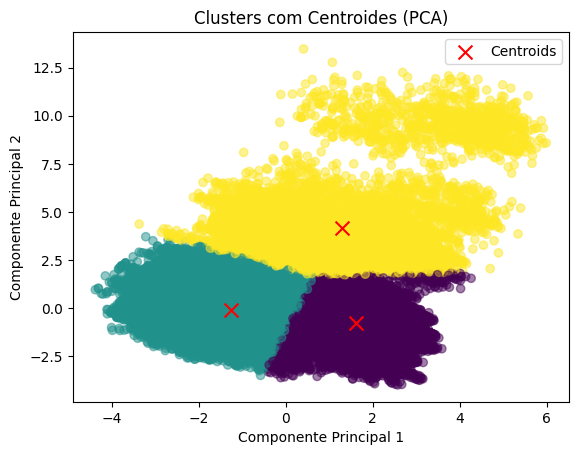

In [ ]:
# Aplicar PCA para reduzir a dimensionalidade
pca = PCA(n_components=2)  # Escolha o número de componentes desejados
X_pca = pca.fit_transform(X_scaled)

# Treinar o modelo K-means com os dados reduzidos pelo PCA
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_pca.fit(X_pca)

# Plotar os clusters com os centroides
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_pca.labels_, cmap='viridis', alpha=0.5)
plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], marker='x', s=100, c='red', label='Centroids')
plt.title('Clusters com Centroides (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.show()


## 3- Identificar a propensão média de cada grupo

In [ ]:
# Identificação da propensão à fraude média de cada grupo
fraud_propensity = loans_data_classif.groupby('Cluster')['Status'].mean()
fraud_propensity

Cluster
0    0.170745
1    0.317966
2    0.280982
Name: Status, dtype: Float64

In [ ]:
# Criar DataFrame a partir dos resultados de fraud_propensity
fraud_propensity_df = fraud_propensity.reset_index()
# Adicionar a nova coluna com base nos valores dos clusters
fraud_propensity_df['Risk Level'] = fraud_propensity_df['Cluster'].map({0: 'Low Risk', 1: 'High Risk', 2: 'Moderate Risk'})
fraud_propensity_df

,Cluster,Status,Risk Level
0,0,0.170745,Low Risk
1,1,0.317966,High Risk
2,2,0.280982,Moderate Risk


In [ ]:
# Salvar DataFrame em um arquivo JSON
fraud_propensity_df.to_json('/content/clusters_result.json', orient='records')

In [ ]:
# Salvar o modelo treinado
joblib.dump(kmeans, 'kmeans_model.pkl')

# Salvar o scaler também se você quiser usá-lo na API
joblib.dump(scaler, 'scaler.pkl')

# Salvar o número de clusters para usar na API
with open('n_clusters.txt', 'w') as f:
    f.write(str(n_clusters))

## 4- Criação da API

### Criação da API Flask

#### Tentativa pelo Google Colab

Conforme pudemos verificar nos testes da API Plumber (R), o Google Colab possui particularidades, que dificultam a criação da API por aqui.
Desta forma, utilizamos o Jupyter Notebook para implementarmos a próxima parte.

#### Tentativa pelo Jupyter Notebook

Foi implementado o arquivo **api_parte2.py** no Jupyter Notebook.
É importante salvar o arquivo do modelo e outros artefatos obtidos durante o treino do modelo em sua pasta, respeitando essa organização:

- root->
  - api_parte2.py
  - config->
    - kmeans_model.pkl
    - scaler.pkl
    - n_clusters.txt
    - clusters_result.json

Código fonte:
```
from flask import Flask, request, jsonify
import numpy as np
import pandas as pd
import joblib

# Funções de apoio
# -------------------------------------------------------------------------------------------------------
def init():
    global clusters_result
    global kmeans
    global scaler
    global n_clusters

    # Carregar a média de propensão de risco dos clusters
    clusters_result = pd.read_json('./config/clusters_result.json')
    # Carregar o modelo K-means
    kmeans = joblib.load('./config/kmeans_model.pkl')
    # Carregar o scaler
    scaler = joblib.load('./config/scaler.pkl')
    # Carregar o número de clusters
    with open('./config/n_clusters.txt', 'r') as f: n_clusters = int(f.read())


def assign_persona(cluster):
    # # Obter o nível de risco correspondente ao cluster
    risk_level = clusters_result.loc[clusters_result['Cluster'] == cluster, 'Risk Level'].iloc[0]
    fraud_propensity = clusters_result.loc[clusters_result['Cluster'] == cluster, 'Status'].iloc[0]
    
    return risk_level, fraud_propensity

def one_hot_encode_columns(df, columns):
    for column in columns:
        df = pd.get_dummies(df, columns=[column])
    return df  

# Definições da API
# -------------------------------------------------------------------------------------------------------
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    # Obter os dados do cliente do request
    data = request.get_json()
    features = data['features']
    loans_data_classif = pd.DataFrame(features)

    # Tratando as colunas categóricas
    columns_to_encode = ['loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness',
                         'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'occupancy_type',
                         'credit_type', 'total_units', 'co_applicant_credit_type', 'age',
                         'submission_of_application', 'Region']    
    loans_data_classif = one_hot_encode_columns(loans_data_classif, columns_to_encode)


    # Garantindo que todas as colunas necessárias estão no dataset
    columns_to_check = ['loan_limit_cf', 'loan_limit_ncf',
                        'approv_in_adv_nopre', 'approv_in_adv_pre',
                        'loan_type_type1', 'loan_type_type2', 'loan_type_type3',
                        'loan_purpose_p1', 'loan_purpose_p2', 'loan_purpose_p3', 'loan_purpose_p4',
                        'Credit_Worthiness_l1', 'Credit_Worthiness_l2',
                        'Neg_ammortization_neg_amm', 'Neg_ammortization_not_neg',
                        'interest_only_int_only', 'interest_only_not_int',
                        'lump_sum_payment_lpsm', 'lump_sum_payment_not_lpsm',
                        'occupancy_type_ir', 'occupancy_type_pr', 'occupancy_type_sr',
                        'credit_type_CIB', 'credit_type_CRIF', 'credit_type_EQUI', 'credit_type_EXP',
                        'total_units_1U', 'total_units_2U', 'total_units_3U', 'total_units_4U',
                        'co_applicant_credit_type_CIB', 'co_applicant_credit_type_EXP',
                        'age_25-34', 'age_35-44', 'age_45-54', 'age_55-64', 'age_65-74', 'age_<25', 'age_>74',
                        'submission_of_application_not_inst', 'submission_of_application_to_inst',
                        'Region_North', 'Region_North-East', 'Region_central', 'Region_south'
                        ]
    
    # Verificar se as colunas estão presentes, atribuindo False para as colunas ausentes
    missing_columns = [col for col in columns_to_check if col not in loans_data_classif.columns]
    for col in missing_columns:
        loans_data_classif[col] = False

    # Forçando a ordem das colunas definida
    ordem_colunas = ['Interest_rate_spread','loan_limit_cf','approv_in_adv_nopre','loan_type_type3','loan_purpose_p4','Credit_Worthiness_l1','Neg_ammortization_not_neg','interest_only_not_int','lump_sum_payment_lpsm','occupancy_type_ir','credit_type_CRIF','total_units_1U','co_applicant_credit_type_EXP','age_25-34','submission_of_application_to_inst','Region_North','loan_limit_ncf','approv_in_adv_pre','loan_type_type1','loan_type_type2','loan_purpose_p1','loan_purpose_p2','loan_purpose_p3','Credit_Worthiness_l2','Neg_ammortization_neg_amm','interest_only_int_only','lump_sum_payment_not_lpsm','occupancy_type_pr','occupancy_type_sr','credit_type_CIB','credit_type_EQUI','credit_type_EXP','total_units_2U','total_units_3U','total_units_4U','co_applicant_credit_type_CIB','age_35-44','age_45-54','age_55-64','age_65-74','age_<25','age_>74','submission_of_application_not_inst','Region_North-East','Region_central','Region_south']
    loans_data_classif = loans_data_classif.reindex(columns=ordem_colunas)
    
    # Padronizar as características e prever o cluster do cliente
    scaled_features = scaler.transform(loans_data_classif)
    cluster = kmeans.predict(scaled_features)[0]
    
    # Atribuir a persona com base no cluster (esta parte você precisa implementar)
    persona, fraud_propensity = assign_persona(cluster)
    
    # Retornar os resultados como JSON
    return jsonify({
        'cluster': int(cluster),
        'persona': persona,
        'fraud_propensity': fraud_propensity
    })
    
    # return loans_data_classif.to_json(orient="records")

# Definir a rota raiz
@app.route("/", methods=['GET', 'POST'])
def call_home(request = request):
    print(request.values)
    return "Parte_2: Server is ready to be used!!!\n"

if __name__ == '__main__':
    init()
    app.run(port=8080, host = '0.0.0.0')
```



Para executar a API localmente, devemos executar no Terminal ou CMD o arquivo **api_parte2.py**:
```
python api_parte2.py
```

Abaixo, evidências do teste.

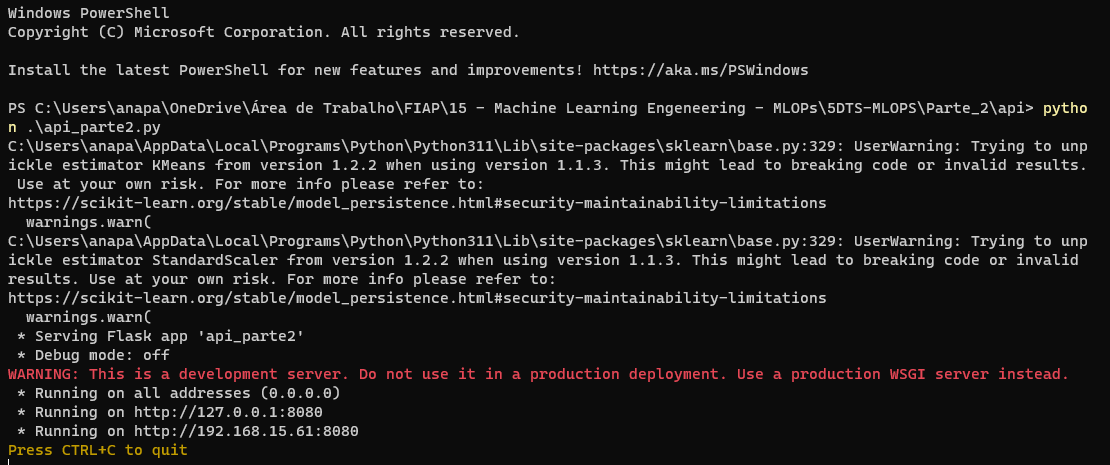

URL da API: http://127.0.0.1:8080/predict

Exemplo de payload:
```
{
    "features": [
        {
            "loan_limit": "cf",
            "approv_in_adv": "nopre",
            "loan_type": "type3",
            "loan_purpose": "p4",
            "Credit_Worthiness": "l1",
            "Interest_rate_spread": 10.39,
            "Neg_ammortization": "not_neg",
            "interest_only": "not_int",
            "lump_sum_payment": "lpsm",
            "occupancy_type": "ir",
            "total_units": "4U",
            "credit_type": "CRIF",
            "co_applicant_credit_type": "EXP",
            "age": "25-34",
            "submission_of_application": "to_inst",
            "Region": "North"
        }
    ]
}
```

Evidência da execução no Postman:

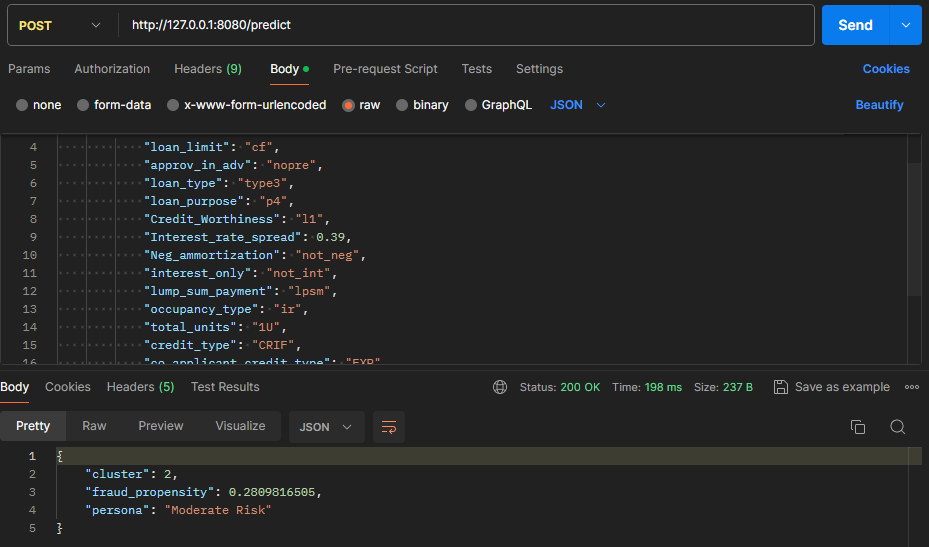

## 5- Encapsular o modelo em um contêiner

### Preparação do arquivo requirements.txt

Nesse momento, é importante salvar em um arquivo as blibliotecas necessárias para que a API execute corretamente.
Para isso, acessar o Terminal ou CMD, salvando o resultado em um arquivo **requirements.txt**.
```
pip freeze
```

Obs.: Esse arquivo deve ser salvo na mesma pasta onde está o arquivo **api_parte2.py**.

### Preparação do arquivo Dockerfile

Salvar um arquivo Dockerfile (sem extensão) o código a seguir:
```
FROM python:3.10
LABEL maintainer="Ana Paula Lavieri"
LABEL version="1.0"

RUN apt-get update
RUN apt-get install nano

RUN mkdir -p /myServer

COPY . /myServer

WORKDIR /myServer

RUN pip install --upgrade pip
RUN pip install -r /myServer/requirements.txt

EXPOSE 8080

CMD [ "python", "api_parte2.py" ]
``


Nesse arquivo estamos preparando a instalação dos componentes necessários para colocar a API em um container.

Basicamente estamos:
- Instalando alguns componentes necessários do Docker
- Copiando os arquivos de nossa solução para a pasta de trabalho
- Instalando as bibliotecas definidas no arquivo requirements.txt
- Expondo o container na porta 8080
- Executando a API api_parte2.py quando o container for chamado

Obs.: Explicamos melhor, de forma global, a preparação dos containers em uma máquina virtual, no arquivo **MLOPS_Trabalho_Integrado.ipynb**.

Abaixo, organização dos arquivos em pastas:

- root->
  - Parte_2->
    - api->
      - config->
        - kmeans_model.pkl
        - scaler.pkl
        - n_clusters.txt
        - clusters_result.json
      - api_parte2.py
      - requirements.txt
    - dockerbuilds->
      - Dockerfile


### Evidência do teste de execução do modelo em Container

Observações:
- A máquina virtual já está preparada
- As imagens do Docker já estão OK
- Os a solução já foi instalada na imagem
- O container já está montado

Para acessar a máquina virtual, utilizamos o comando, informando a senha quando foi solicitada:
```
ssh vm-grupo-mlops@52.226.67.177
```

Conferindo a montagem dos containers (o deste modelo é o parte2_api)
```
sudo docker ps
```

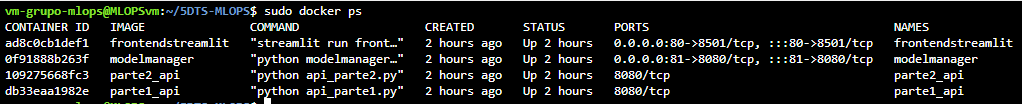

Executando um GET simples, apenas para conferir se o serviço está OK
```
curl http://172.19.0.3:8080/
```

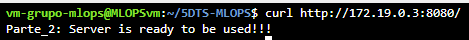

Executando o modelo propriamente dito
```
curl -X POST -H "Content-Type: application/json" -d '{"model":"parte1_api","features": [{"loan_limit": "cf","approv_in_adv": "nopre","loan_type": "type3","loan_purpose": "p4","Credit_Worthiness": "l1","Interest_rate_spread": 0.39,"Neg_ammortization": "not_neg","interest_only": "not_int","lump_sum_payment": "lpsm","occupancy_type": "ir","total_units": "1U","credit_type": "CRIF","co_applicant_credit_type": "EXP","age": "25-34","submission_of_application": "to_inst","Region": "North"}]}' http://172.19.0.3:8080/predict
```

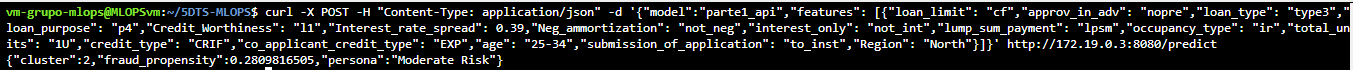